# Finite Differences

In [1]:
#Librairies
import numpy as np # Créer des vecteurs/matrices et autres opérations
from scipy.integrate import odeint # Pour résoudre des équations différentielles
from scipy.sparse import diags # Créer des matrices spécifiques
import scipy.linalg as la # Faire de l'algèbre linéaire
import matplotlib.pyplot as plt # Pour faire des graphiques

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Exo 1

Solve Poisson equation,

$u''(x) = 6x$,

in the interval $0 \le x \le 1$, subject to boundary conditions,

$u'(0) = 0, \quad u(1) = 1$.

Compare two implementation of the boundary conditions: one - by elimination of dependant variables and another - by replacing lines in the system of equations.

Compare your approximate solution to the exact solution given by

$u(x) = x^3$.

Avant de commencer la résolution détaillée, je rappel que le but de ces notebooks n'est pas d'expliquer le cours en détails, mais bien d'expliquer python.
Pour plus d'information sur comment fonctionne la méthode des différences finies, je vous renvoie au notebook 3.01 du cours.

On commence par définir la matrice des différences finies *d2mat2nd* qui est une matrice diagonale dont les valeurs sont les coefficients des différences finies. ces coefficients dépendent de la méthode utilisé (forward, backward ou centered), de l'ordre de la dérivée et de l'ordre de la précision. les coéfficients sont donnée dans le cours (les notebooks 3.01 et 3.02) ou peuvent être trouvé ici : https://en.wikipedia.org/wiki/Finite_difference_coefficient.

Dans cette exercice on utilise les différences finies centré pour une dérivée seconde avec une précision d'ordre 2, les coefficiens sont (1, -2, 1) et le stencil [-1,0,1]. Les différences finies centré pour une dérivée seconde d'ordre 2 de précision ne peuvent pas être appliqué pour les points au bord gauche et droit de l'intervalle, de ce fait on remplace la première ligne (correspondant au bord gauche) et la dernière ligne (correspondant au bord droit) par, respectivement, les coefficients des différences finies pour les dérivées secondes d'ordre 2 de précision forward et backward. Les coefficients sont, respectivement, (2, -5, 4, -1) et (-1, 4, -5, 2).

In [6]:
# Création de la matrice d2mat2nd
def d2mat2nd(nx, dx):
    coeffs = [[1.0], [-2.0], [1.0]] # Les éléments sur la diagonale principale
    offsets = [-1, 0, 1] # la position des diagonales par rapport la diagonale principale
    
    mat = diags(coeffs, offsets, shape=(nx, nx)).A / dx ** 2 # Création de la matice en utilisant diags
    mat[0, :4] = np.array([2.0, -5.0, 4.0, -1.0]) / dx ** 2 # on remplace le bord gauche
    mat[-1, nx - 4:] = np.array([-1.0, 4.0, -5.0, 2.0]) / dx ** 2 # on remplace le bord droit
    
    return mat

'''
Pour résoudre ce problème, on a commencé par créer la fonction 'd2mat2nd' qui construit la matrice des différences finies centrées pour la dérivé
du second ordre. Pour la créer, on utilise 'python definition' qui prend deux arguments en entrée (nx, dx), respectivement, le nombre de point de la
grille et la distance entre deux points.
On utilise la fonction 'diag' de la librairie 'Scipy'. Cette fonction demande comme entrée un vecteur et renvoie une matrice remplie de 0 avec les
éléments de notre vecteur comme diagonal de la matrice. On peut également lui donnée d'autres entrées facultatifs comme offset qui vous donne la postion
des diagonales par rapport à la diagonale principale (exemple : offset = [-1, 0, 1]; 0 correspond à la diagonal principale, -1 à la diagonale à gauche
de la diagonale principale, 1 celle à droite). 

Regardons un exemple d'utilisation de la fonction diag :
    diagonale = [[1,2,3,4], [1,2,3], [1,2]]
    offset = [0, -1, 2]
    
    print(diags(diagonale, offset).toarray())
résultat : 
    [[1. 0. 1. 0.]
     [1. 2. 0. 2.]
     [0. 2. 3. 0.]
     [0. 0. 3. 4.]]    

On voit que l'on retrouve une matrice avec le premier terme de 'diagonale = [1,2,3,4]' qui est en diagonale de la matrice selon le premier terme
de 'offset = 0' soit sur la diagonale principale. Le deuxième terme de 'diagonale = [1,2,3]' se retrouve placé par rapport au deuxième terme de 
'offset = -1' soit à gauche de la diagonale principale. et le troisième terme de 'diagonale = [1,2]' se retrouve placé par rapport au troisième terme
de 'offset = 2' soit la deuxième diagonale à droite de le diagonale principale.

Ensuite, après avoir créé la matrice des différences fini centré, On remplace la première et la dernière ligne par les différences finies à gauche et 
à droite. Pour ce faire, on utilise python slicing qui est très bien expliqué dans le cours (notebook 3.01) et également dans la documentation ci desous.
'''

"\nPour résoudre ce problème, on a commencé par créer la fonction 'd2mat2nd' qui construit la matrice des différences finies centrées pour la dérivé\ndu second ordre. Pour la créer, on utilise 'python definition' qui prend deux arguments en entrée (nx, dx), respectivement, le nombre de point de la\ngrille et la distance entre deux points.\nOn utilise la fonction 'diag' de la librairie 'Scipy'. Cette fonction demande comme entrée un vecteur et renvoie une matrice remplie de 0 avec les\néléments de notre vecteur comme diagonal de la matrice. On peut également lui donnée d'autres entrées facultatifs comme offset qui vous donne la postion\ndes diagonales par rapport à la diagonale principale (exemple : offset = [-1, 0, 1]; 0 correspond à la diagonal principale, -1 à la diagonale à gauche\nde la diagonale principale, 1 celle à droite). \n\nRegardons un exemple d'utilisation de la fonction diag :\n    diagonale = [[1,2,3,4], [1,2,3], [1,2]]\n    offset = [0, -1, 2]\n    \n    print(diags(dia

In [7]:
# Création de la grille
nx = 100 # Le nombre de point dans la grille 
x = np.linspace(0.0, 1.0, nx)
dx = x[1] - x[0] # l'espacement entre deux points de la grille

In [8]:
# Implémentation de la première solution
amat = d2mat2nd(nx, dx) # Calcule de la matrice de différence fini centré pour notre problème

rhs = (6 * x - 1.0 * amat[:, -1])[1:-1] # On définie le membre de droite de notre équation
lhs = amat[1:-1, 1:-1] # On définie le membre de gauche de notre équation
lhs[0, :2] += np.array([4 / 3, -1 / 3]) / dx ** 2 # On inclue les conditions au bord

u_1 = la.solve(lhs, rhs) # On utilise la fonction solve pour résoudre notre équation

'''
On a commencé, ici, par déterminer la matrice de différence fini centré pour notre problème en utilisant la fonction 'd2mat2nd'
définie ci-dessus.
On l'utilise pour définir le coté droit de l'équation ('rhs') et le coté gauche ('lhs'). Remarqué que pour les deux côté, on ne
prend pas toute la matrice mais on utilise le slicing pour ne récupérer que la partie centrale. Pourquoi ? Car les différences
fini centrées ne sont pas définie au bords (voir cours pour plus d'information). 

Pour résoudre notre problème, on utilise la fonction 'solve' de la librairie 'scipy.linalg' qui contient plein de fonction pour
résoudre des problèmes d'algèbre linéaire. Cette fonction 'solve' effectue le calcule suivant : Inverse de lhs * rhs
(On pourrait également le coder comme ceci : u = la.inv(Ap) @ F; c'est un peu plus explicite).
'''

"\nOn a commencé, ici, par déterminer la matrice de différence fini centré pour notre problème en utilisant la fonction 'd2mat2nd'\ndéfinie ci-dessus.\nOn l'utilise pour définir le coté droit de l'équation ('rhs') et le coté gauche ('lhs'). Remarqué que pour les deux côté, on ne\nprend pas toute la matrice mais on utilise le slicing pour ne récupérer que la partie centrale. Pourquoi ? Car les différences\nfini centrées ne sont pas définie au bords (voir cours pour plus d'information). \n\nPour résoudre notre problème, on utilise la fonction 'solve' de la librairie 'scipy.linalg' qui contient plein de fonction pour\nrésoudre des problèmes d'algèbre linéaire. Cette fonction 'solve' effectue le calcule suivant : Inverse de lhs * rhs\n(On pourrait également le coder comme ceci : u = la.inv(Ap) @ F; c'est un peu plus explicite).\n"

In [13]:
# Implémentation de la deuxième solution
rhs = 6*x # On définie le membre de droite de notre équation
lhs = amat.copy() # On définie le membre de gauche de notre equation

'''
Ici, le membre de gauche est la matrice de différence fini centré pour notre problème soit celle définie ci-dessus 'amat' trouvé
à l'aide de la fonction 'd2mat2nd'. On n'a pas simplement écrit : lhs = amat. Mais : lhs = amat.copy(). .Copy() est une fonction
qui va copier le contenu d'une variable et la coller dans une autres. De cette manière on s'assure que lhs ne soit pas modifié par
le code qui suit. 
'''



lhs[0] = np.zeros(nx) # On remplace la première entrée de 'lhs' par la dérivée de notre fonction en x = 0  
lhs[0,0:3] = np.asarray([-3/2, 2, -1/2]) / dx # 
rhs[0] = 0 # on remplace la première entrée de 'rhs' par 0

'''
Ici, on veut implémenter nos conditions au bords manuellement et on commence par remplacé la première entrée de 'lhs' et 'rhs' dans
le but d'implémenter u'(x) = 0. On utilise la fonction 'np.asarray(x)' de numpy qui prend une entrée 'x' et la transforme
en un vecteur.
'''

lhs[-1] = np.zeros(nx) # On remplace la dernière entrée de 'lhs' par 1 
lhs[-1,-1] = 1
rhs[-1] = 1 # on remplace la dernière entrée de 'rhs' par 1

'''
On implémente la condition u(1) = 1.
'''

u_2 = la.solve(lhs, rhs) # On résoud

'''
Tout comme au-dessus, on résoud notre problème en utilisant 'solve'.
'''

"\nTout comme au-dessus, on résoud notre problème en utilisant 'solve'.\n"

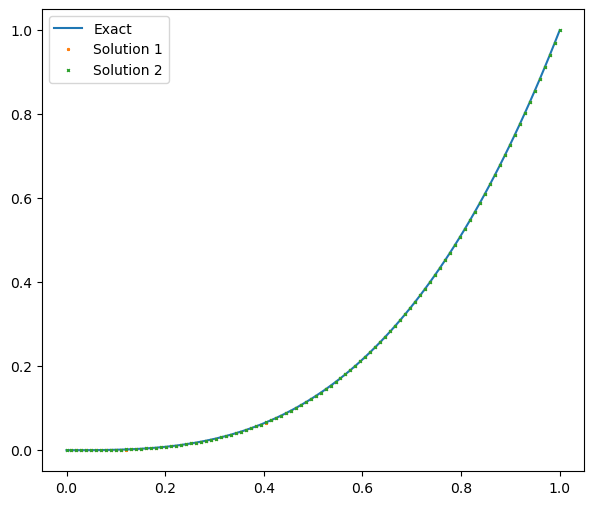

In [15]:
# On plot tout ça
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

ax.plot(x, x ** 3, label="Exact")
ax.plot(x[1:-1], u_1, "*", markersize=2, label="Solution 1")
ax.plot(x, u_2, "x", markersize=2, label="Solution 2")

ax.legend()

### Documentations

Scipy.diags : https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.diags.html

Scipy.linalg : https://docs.scipy.org/doc/scipy/reference/linalg.html

.copy() : https://www.programiz.com/python-programming/methods/list/copy

np.asarray : https://numpy.org/doc/stable/reference/generated/numpy.asarray.html